## Image Preprocessing

- resizing
- normalising
- denoising
- color scale transformation
- contrast enhancement
- edge detection (out)

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import shutil
from tqdm import tqdm

# Load an image
image_path = "C:/Applied_Machine_Learning/Project/Data/master_data/validate/image_00020_Jason_2021.jpg"
trail_image = cv2.imread(image_path)
convert_image = cv2.cvtColor(trail_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct plotting

In [2]:
def display_images(original, processed, title1='Original', title2='Processed'):
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(original), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(processed), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()


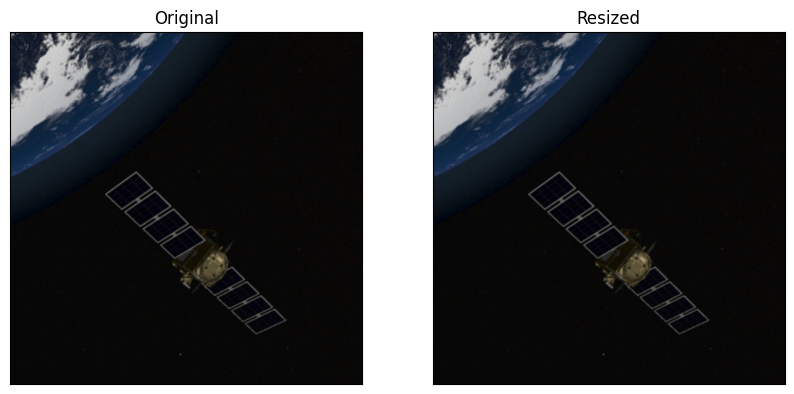

In [3]:
def resize_image(image, size=(640, 640)):
    """ Resize image to given size. """
    return cv2.resize(image, size)

resized_image = resize_image(convert_image)  # You can use resized_image for further processing
display_images(convert_image, resized_image, 'Original', 'Resized')


def normalize_image(image):
    """ Normalize image pixels between 0 and 1 """
    return image / 255.0

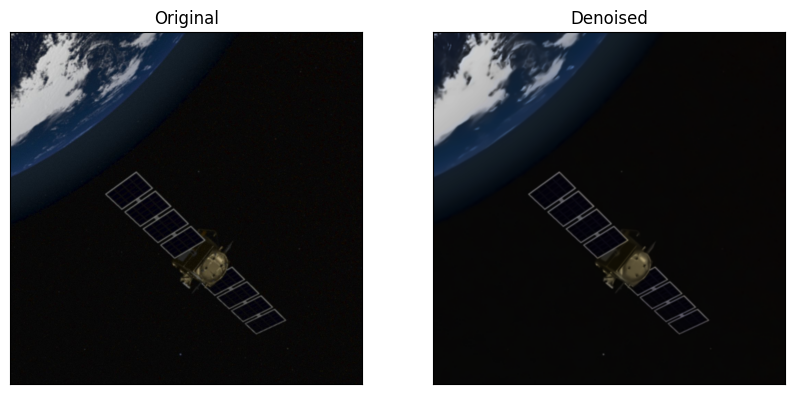

In [4]:
def denoise_image(image, method='non_local_means'):
    """ Denoise image using specified method. """
    if method == 'non_local_means':
        return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    elif method == 'gaussian_blur':
        return cv2.GaussianBlur(image, (5, 5), 0)
    elif method == 'bilateral':
        return cv2.bilateralFilter(image, 9, 75, 75)
    else:
        return image

denoised_image = denoise_image(resized_image)
display_images(convert_image, denoised_image, 'Original', 'Denoised')

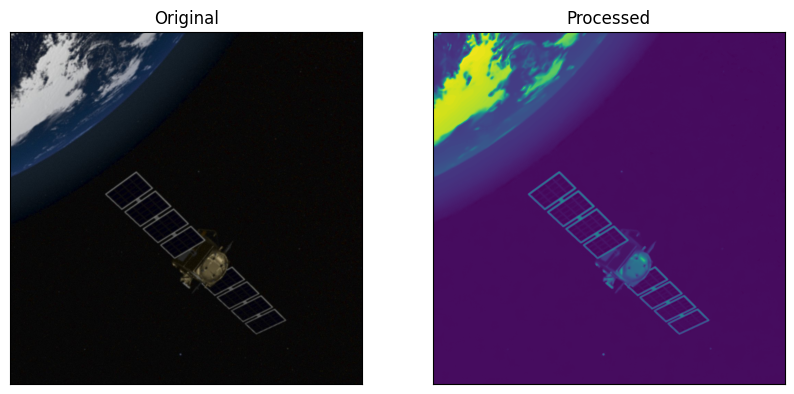

In [5]:
def convert_color_space(image, target_space='HSV'):
    """ Convert image to the specified color space. """
    if target_space == 'HSV':
        return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif target_space == 'LAB':
        return cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    elif target_space == 'GRAY':
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        return image

color_space_image = convert_color_space(denoised_image, 'GRAY')
display_images(convert_image, color_space_image, 'Original')

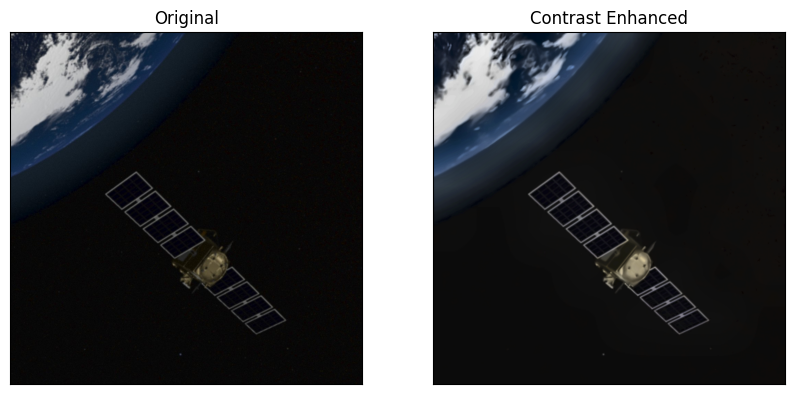

In [6]:
def enhance_contrast(image, method='CLAHE'):
    """ Enhance contrast using specified method. """
    if method == 'CLAHE':
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        if len(image.shape) == 3 and image.shape[2] == 3:  # Color image
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            l2 = clahe.apply(l)
            lab = cv2.merge((l2, a, b))
            return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        else:  # Grayscale image
            return clahe.apply(image)
            
    elif method == 'hist_equal':
        if len(image.shape) == 3 and image.shape[2] == 3:  # Color image
            ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
            channels = cv2.split(ycrcb)
            cv2.equalizeHist(channels[0], channels[0])
            cv2.merge(channels, ycrcb)
            return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
        else:  # Grayscale image
            return cv2.equalizeHist(image)
    else:
        return image

enhanced_image = enhance_contrast(denoised_image)
display_images(convert_image, enhanced_image, 'Original', 'Contrast Enhanced')

In [7]:
def adjust_bbox(bbox, original_size, new_size):

    # Convert string representation of bbox into a list of integers
    bbox_values = [int(value) for value in bbox.strip('[]').split(',')]

    y_min, x_min, y_max, x_max = bbox_values
    orig_height, orig_width = original_size
    new_height, new_width = new_size

    # Compute scale factors for height and width
    scale_h = new_height / orig_height
    scale_w = new_width / orig_width

    # Adjust bounding box coordinates
    adjusted_y_min = int(y_min * scale_h)
    adjusted_x_min = int(x_min * scale_w)
    adjusted_y_max = int(y_max * scale_h)
    adjusted_x_max = int(x_max * scale_w)

    return adjusted_y_min, adjusted_x_min, adjusted_y_max, adjusted_x_max


In [8]:
def process_image_with_bbox(image, adjusted_bbox):
    
    # Draw adjusted bounding box on preprocessed image
    y_min, x_min, y_max, x_max = adjusted_bbox
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    padding = 100
    
    # Add padding to the bounding box coordinates
    y_min = max(0, y_min - padding)
    x_min = max(0, x_min - padding)
    y_max = min(image.shape[0], y_max + padding)
    x_max = min(image.shape[1], x_max + padding)

    # Crop image based on bounding box (commented out for now)
    cropped_image = image[y_min:y_max, x_min:x_max]

    # Return the modified image
    return cropped_image
    

In [9]:
import cv2
import pandas as pd
import ast 
import os
import shutil
from tqdm import tqdm

# Load the Excel file
label_path = "C:/Applied_Machine_Learning/Project/Data/master_data/label/final_data_label.csv"

label = pd.read_csv(label_path)
df = label[(label['usage'] == 'train') | (label['usage'] == 'validate')]
df = df[['filename', 'class', 'bbox', 'usage']].sample(frac = 1, random_state = 32)

# Assuming 'label' is the column with numerical values
# df['class'] = df['class'].replace({1: 'satellite', 0: 'debris'})

# df = df.head(10000)
# df.to_csv('samplePreprocessedData.csv', index = False)
# df.sample(frac= 1, random_state=32)
# Data Directory
src_folder = 'C:/Applied_Machine_Learning/Project/Data/master_data/'
dest_folder = 'C:/Applied_Machine_Learning/Project/Data/preprocessed_data/'

# Check if the destination folder is not empty
if os.path.exists(dest_folder):
    # Remove the entire directory and its contents
    shutil.rmtree(dest_folder)

# Function to process and save images
def process_and_save_image(src_path, dest_path, bbox):
    try:
        # Read the image
        image = cv2.imread(src_path) 
        
        original_image = image.copy()
        original_size = (image.shape[0], image.shape[1])

        # Resize the image using bilinear interpolation (default)
        image = resize_image(image)  # Possible methods: 'bilinear', 'nearest', 'bicubic'
        
        # Denoise the image using non-local means denoising (default)
        image = denoise_image(image)  # Possible methods: 'non_local_means', 'gaussian_blur', 'bilateral'
        
        # Convert color space to HSV (default)
        # image = convert_color_space(image)  # Possible color spaces: 'HSV', 'LAB', 'GRAY'
        
        # Enhance contrast using CLAHE (default)
        image = enhance_contrast(image)  # Possible methods: 'CLAHE', 'hist_equal'
        
        # Normalize the image
        # image = normalize_image(image)

        # Adjust bounding box coordinates
        adjusted_bbox = adjust_bbox(bbox, original_size, image.shape[:2])  

        # Plotting Bbox on the image
        image = process_image_with_bbox(image, adjusted_bbox)

        # Save the preprocessed image to the destination folder
        cv2.imwrite(os.path.join(dest_path, os.path.basename(src_path)), image)
    
    except Exception as e:
        print(f"Error processing image: {src_path}. {e}")

# Process each image in the dataframe
for ind in tqdm(df.index):
    if df.loc[ind, 'usage'] == 'train':
        src_path = os.path.join(src_folder, 'train', df.loc[ind, 'filename'])
        dest_path = os.path.join(dest_folder, 'train')
    else:
        src_path = os.path.join(src_folder, 'validate', df.loc[ind, 'filename'])
        dest_path = os.path.join(dest_folder, 'validate')

    # Ensure the destination folder exists
    os.makedirs(dest_path, exist_ok=True)

    # Process and save the image
    process_and_save_image(src_path, dest_path, df.loc[ind, 'bbox'])


  0%|                                                                            | 21/56000 [00:22<16:33:46,  1.07s/it]


KeyboardInterrupt: 